In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 119.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
df = pd.read_excel("DJIA RV.xlsx",index_col='Date',parse_dates=True)

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [ ]:
df.head()

,ds,wasserstein_dists_2D,y,VIX,unique_id
0,2000-02-01,0.067382,0.008479,23.450001,airplane1
1,2000-02-02,0.049767,0.008538,23.120001,airplane1
2,2000-02-03,0.039045,0.015446,22.010000,airplane1
3,2000-02-04,0.037064,0.008933,21.540001,airplane1
4,2000-02-07,0.042502,0.007626,22.790001,airplane1


In [ ]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]
RMSE = []
Accuracy = []

# H=4 Forecasts

In [ ]:
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [ ]:
model = NBEATSx(h=4, input_size=21,
                loss=losses[1],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['trend','seasonality'],
                n_blocks=[3,3],
                mlp_units= [[100, 100], [100, 100]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=62584243
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=4,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%4,step_size=4)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat1=forecasts["NBEATSx"].values
else:
  Y_hat1=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat1)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat1-np.log(Y_true/Y_hat1)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 62584243


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.4822%
QLIKE: 8.51%


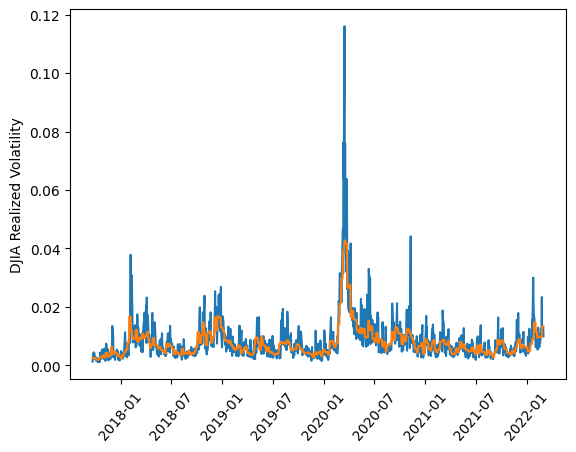

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat1) 
plt.ylabel("DJIA Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [ ]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast with PH': Y_hat1
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast with PH (NBEATSx).csv")

# H=6 Forecasts

In [ ]:
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [ ]:
model = NBEATSx(h=6, input_size=21,
                loss=losses[1],
                scaler_type='standard',
                learning_rate= 0.00005,
                stack_types=['trend','seasonality'],
                n_blocks=[3,3],
                mlp_units= [[100, 100], [100, 100]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=62584243
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=6,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%6,step_size=6)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat1=forecasts["NBEATSx"].values
else:
  Y_hat1=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat1)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat1-np.log(Y_true/Y_hat1)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 62584243


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.5143%
QLIKE: 9.35%


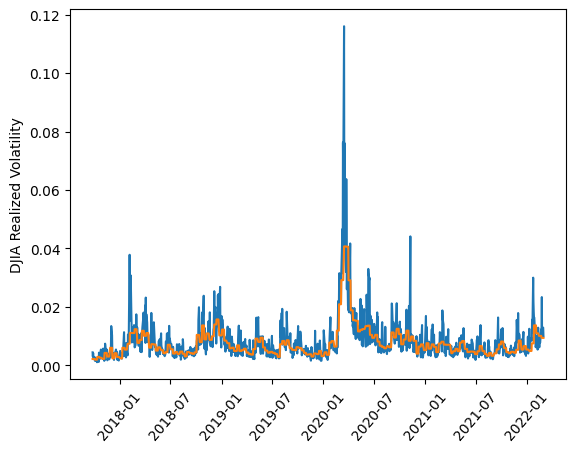

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat1) 
plt.ylabel("DJIA Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [ ]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast with PH': Y_hat1
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast with PH (NBEATSx).csv")